In [1]:
import cv2
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

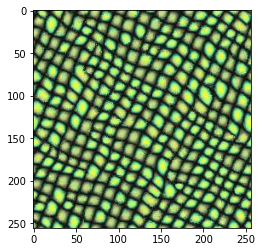

In [2]:
img = plt.imread("path/to/img.jpg")
plt.imshow(img)

(64, 64, 3)

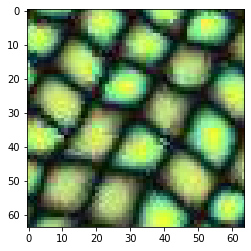

In [23]:
patch_img = img[93:157, 93:157, :]
plt.imshow(patch_img) 
patch_img.shape

In [24]:
print("original image size:",img.shape)
print("Patch image size:",patch_img.shape) 

original image size: (256, 256, 3)
Patch image size: (64, 64, 3)


In [4]:
def getIntialSynthesisImage(sample_patch, size):
    
    """
    assumption would be sample_patch has even dimesions
    size is max value upto which image would expand
    """

    synth_image = np.full((size, size, 3), -1)
    nor_synth_image = np.full((size, size, 3), -1).astype('float32')
    
    center = (int(size/2), int(size/2))

    row_strt = center[0] - int(sample_patch.shape[0]/2)
    row_end  = center[0] + int(sample_patch.shape[0]/2)
    col_strt = center[1] - int(sample_patch.shape[1]/2)
    col_end  = center[1] + int(sample_patch.shape[1]/2)

    synth_image[row_strt:row_end, col_strt:col_end] = sample_patch
    nor_synth_image[row_strt:row_end, col_strt:col_end] = (sample_patch - sample_patch.min())/(sample_patch.max() - sample_patch.min())

    return synth_image, nor_synth_image

def doImagePadding(image, normalised_image, window_size):
    
    # padding for both size(so 2 multiplication)
    pad_size = 2 * (window_size//2)
    half_pad_size = window_size // 2

    # new image which is padded over the original
    new_image = np.zeros((image.shape[0]+pad_size, image.shape[1]+pad_size, 3))
    new_normalised_image = np.zeros((image.shape[0]+pad_size, image.shape[1]+pad_size, 3))

    # original image placing within new image
    new_image[half_pad_size:image.shape[0]+half_pad_size, half_pad_size:image.shape[1]+half_pad_size, :] = image
    new_normalised_image[half_pad_size:image.shape[0]+half_pad_size, half_pad_size:image.shape[1]+half_pad_size, :] = normalised_image

    return new_image.astype('uint8'), new_normalised_image


In [8]:
def getExtreamIndexs(synth_image):

    """
    2 point locations(Extream top left, Extream right bottom) 
    to get unfilled neighbours locations deatils(spatial) returned.
    """

    # Four extream points to whch doesn't filled till
    ext_row_strt, ext_col_strt = 0, 0
    ext_row_end, ext_col_end = synth_image.shape[0]-1, synth_image.shape[1]-1

    # stop flag
    stop_iter = False

    # move over left to right and top to bottom direction to find first unfilld pixel
    for row_idx in range(synth_image.shape[0]):

        for col_idx in range(synth_image.shape[1]):

            if synth_image[row_idx][col_idx][0] != -1:
                if row_idx != 0:
                  ext_row_strt = row_idx-1
                if col_idx != 0: 
                  ext_col_strt = col_idx-1
                stop_iter = True
                break

        if stop_iter:
            break
    
    stop_iter = False
    # move over right to left and bottom to top direction to find last unfilld pixel
    for row_idx in range(synth_image.shape[0]-1, 0 , -1):

      for col_idx in range(synth_image.shape[1]-1, 0, -1):

          if synth_image[row_idx][col_idx][0] != -1:
              if row_idx != synth_image.shape[0]-1:
                ext_row_end = row_idx+1
              if col_idx != synth_image.shape[1]-1: 
                ext_col_end = col_idx+1
              stop_iter = True
              break

      if stop_iter:
          break

    return (ext_row_strt, ext_col_strt, ext_row_end, ext_col_end)

def getUnfilledNeighbour(synth_image, window_size):

    """
    pixel locations which are unfilled but surrounded neighbours filled are returned.
    synth_image have some of the pixels are alrady filled and some are not.
    """

    ext_row_strt, ext_col_strt, ext_row_end, ext_col_end = getExtreamIndexs(synth_image)

    # Each elememnt would contain 2 object as in single tuple
    # First element would be tuple(within main tuple!) with index information(row, col)
    # Second element would be int represents number of filled neighbours on surrounding window indexes
    unfilled_neighbours = []
    half_wndo_size = window_size // 2

    # move over outer boundary patch
    for row_idx in range(ext_row_strt, ext_row_end+1):
        for col_idx in range(ext_col_strt, ext_col_end+1):

            if synth_image[row_idx][col_idx][0] == -1:

                # patch corresponding window size(color channel position not important as if one channel value is -1 then other two as well)
                wndo_patch = synth_image[row_idx-half_wndo_size : row_idx+half_wndo_size+1, 
                                         col_idx-half_wndo_size : col_idx+half_wndo_size+1, 
                                         0]
                
                # index of unfilled pixel and nubers of filled neighbour on surrounding
                neighbours = ((row_idx, col_idx), len(np.where(wndo_patch != -1)[0])-1)
                # store the neighbours
                unfilled_neighbours.append(neighbours)

    # Sort according to descending numbers of surrounding filled neighbours 
    unfilled_neighbours.sort(key=lambda x:x[1], reverse = True)    

    return unfilled_neighbours

# plt.imshow(doImagePadding(img, 25))

In [16]:
def getNeighborhoodWindow(synth_image, pixel_loc, window_size):
    """
    returns template around the specific pixel location equal to size of window
    """

    half_window_size = window_size//2

    # template at  location pixel_loc(row, col)
    template = synth_image[pixel_loc[0]-half_window_size : pixel_loc[0]+half_window_size+1,
                           pixel_loc[1]-half_window_size : pixel_loc[1]+half_window_size+1,
                           :]
    return template

def getGaussian3DKernel(window_size):

    # 2D zeros matrix 
    visualization_matrix = np.zeros((window_size, window_size))
    # Ceter pixel stores as one 
    visualization_matrix[int(window_size/2), int(window_size/2)] = 1.0

    # Generate 2D kerenl so that center value 1 is distribute normally to entire matrix
    # So that center part get the highest value
    gauss_kernel_2D = cv2.GaussianBlur(visualization_matrix, 
                                      (window_size, window_size),
                                      window_size/6.4, 
                                      borderType=cv2.BORDER_ISOLATED)
    
    # (window_size, window_size) -> (window_size, window_size, 3)
    gauss_kernel_3D = np.stack((gauss_kernel_2D, gauss_kernel_2D, gauss_kernel_2D),axis=2)

    return gauss_kernel_3D

def getValidKernel(template):

    valid_kernel = template.copy()

    # get the indices to fill accordingly
    unfilled_indices = np.where(template == -1)
    filled_indices = np.where(template != -1)

    # filling the indices
    valid_kernel[unfilled_indices] = 0
    valid_kernel[filled_indices] = 1

    return valid_kernel


def findTheBestMatches(image, template, window_size):
    
    # print(template)
    half_wndo_size = window_size//2

    # Valid Kernel of ones and zeros
    valid_kernel = getValidKernel(template)

    # Gaussian Kernel
    gauss_kernel = getGaussian3DKernel(window_size)

    # Gaussian weight matrix corresponds to filled values in original image
    weights = valid_kernel*gauss_kernel
    tot_weight = weights.sum()

    # minimum ssd will help to find useful pixel value within image
    min_ssd = sys.maxsize

    # storing the values of ssd along with location information
    ssd_list = []

    #template preprocessing
    template *= valid_kernel
    # print(template)

    best_match = 0
    # move over each original image pixel except the padding part
    for row_idx in range(half_wndo_size, image.shape[0]-half_wndo_size):
        for col_idx in range(half_wndo_size, image.shape[1]-half_wndo_size):

            # patch of original match
            orig_img_patch = image[row_idx-half_wndo_size : row_idx+half_wndo_size+1, 
                                   col_idx-half_wndo_size : col_idx+half_wndo_size+1, 
                                   :] 
            
            # sum of square distance
            ssd = (np.square(orig_img_patch - template) * weights ).sum() / tot_weight

            # save the ssd value with location information
            ssd_list.append(((row_idx, col_idx), ssd))

            if ssd < min_ssd:
                min_ssd = ssd

    # pixels only which follows threshold criterion
    best_matches = []

    # Threshold for the error value
    err_threshold = 0.1

    # Filter the only useful pixels
    for pixel_loc, ssd in ssd_list:
        # Store the pixel value if ssd is more than required criterion
        if ssd <= min_ssd*(1 + err_threshold):
            best_matches.append((pixel_loc, ssd))

    return best_matches

def fillThePixels(image, normalised_image, synth_image, normalised_synth_image, window_size, pixels_list, max_error_threshold):
    

    for pixel_loc, neighhbours in pixels_list:

        # Get template for specifc loaction to match with original image
        template = getNeighborhoodWindow(normalised_synth_image, pixel_loc, window_size)

        # The best mactches in images will be fetched
        best_matches = findTheBestMatches(normalised_image, template.copy(), window_size)

        # max error thrshold for the best matching
        max_error_threshold = 0.3

        # Flag to pixel filling
        complete = False

        while not complete:

            # Sample the one random pixel value from best macthces
            best_match = random.choice(best_matches)
            # best_match = best_matches
            org_pixel_loc, ssd = best_match
            
            # fill the pixel if it satisfy the crieterion 
            if ssd < max_error_threshold:
               
                # Update synthesize image
                synth_image[pixel_loc[0], pixel_loc[1], :] = image[org_pixel_loc[0], org_pixel_loc[1], :]
                # Update normalised synthesis image
                normalised_synth_image[pixel_loc[0], pixel_loc[1], :] = normalised_image[org_pixel_loc[0], org_pixel_loc[1], :]
  
                complete = True
            
            # If criterion not satisfy increase the thrshold value
            else:
                max_error_threshold *= 1.1

    return synth_image, normalised_synth_image

Iter : 1


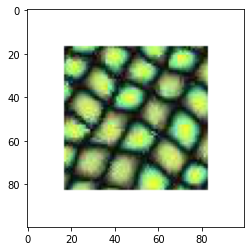

Iter : 2


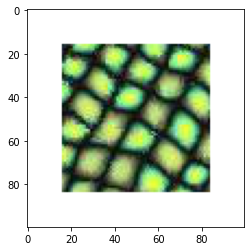

Iter : 3


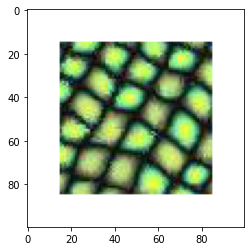

Iter : 4


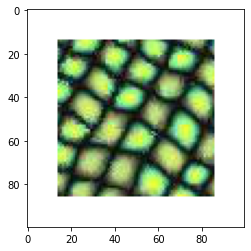

Iter : 5


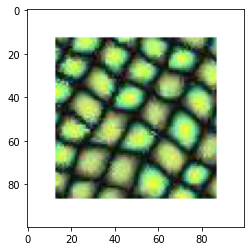

Iter : 6


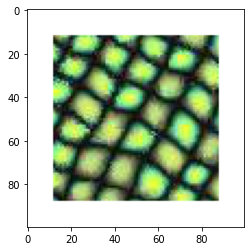

Iter : 7


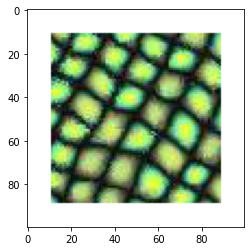

Iter : 8


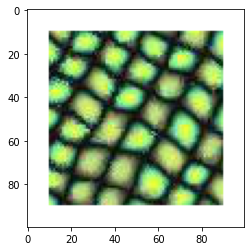

Iter : 9


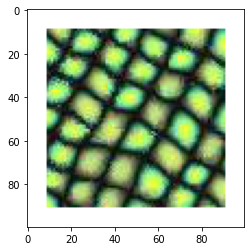

Iter : 10


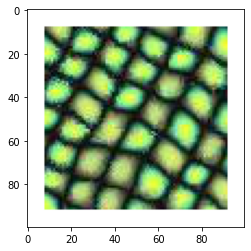

Iter : 11


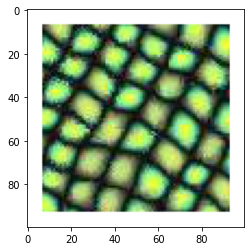

Iter : 12


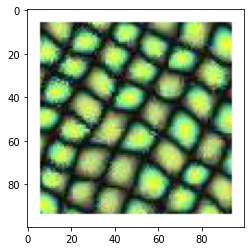

Iter : 13


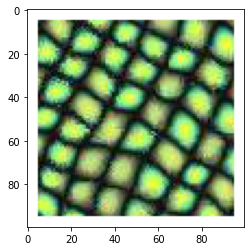

Iter : 14


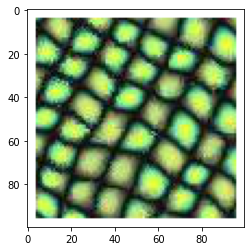

Iter : 15


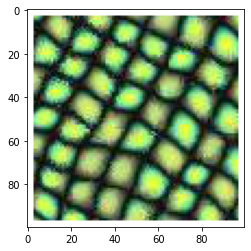

Iter : 16


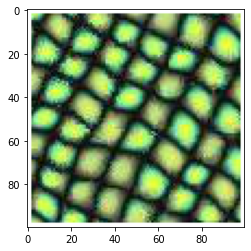

Iter : 17


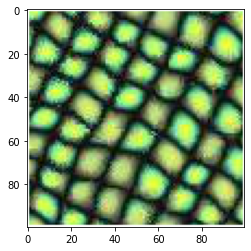

Iter : 18


In [25]:
def growImage(sample_patch, image, window_size, grow_size):
    
    half_window_size = window_size // 2
    
    # Intialsie synthesis image with required grow size where 
    # in the center part paatch would be present
    synth_image, normalised_synth_image = getIntialSynthesisImage(sample_patch, grow_size)

    # nomalise image(range between 0 and 1) for calculation 
    normalised_image = (image - image.min())/(image.max() - image.min())
    normalised_image = normalised_image.astype('float32')

    # image is padded according to window size
    image, normalised_image =  doImagePadding(image, normalised_image, window_size)
    
    # Flag to stop the algorithm
    image_grown_complete = False

    # maximum threshold to fill the image pixel value in synthesized image
    max_error_threshold = 0.3

    # store the growing images images
    growing_images = []
    iter = 1


    while not image_grown_complete:

        print("Iter :",iter)
        iter += 1

        # get list of unfilled pixels
        pixels_list = getUnfilledNeighbour(synth_image, window_size)

        # terminating case(each pixel in synth_image filled by some value)
        # or 
        if len(pixels_list) == 0 or iter > (grow_size - (2 * half_window_size) - sample_patch.shape[0])/2:
            image_grown_complete = True
            continue

        # filled the pixel by' matching algorithm
        synth_image, normalised_synth_image = fillThePixels(image, normalised_image, synth_image, 
                                                            normalised_synth_image, window_size, 
                                                            pixels_list, max_error_threshold)
        
        print_img = synth_image[half_window_size:grow_size-half_window_size, half_window_size:grow_size-half_window_size, :].copy()
        growing_images.append(print_img.astype('uint8'))

        plt.figure()
        plt.imshow(print_img.astype('uint8'))
        plt.show()
      
    return growing_images
    

sequence_of_images = growImage(sample_patch=patch_img, image=img, window_size=5, grow_size=104)

In [27]:
# store the image as gif
import imageio
imageio.mimsave('path/to/save/.gif', sequence_of_images)